In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.dataset.split import split
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.mx import DeepAREstimator, TemporalFusionTransformerEstimator
from gluonts.mx.trainer import Trainer

Load the data

In [2]:
ds = get_dataset("london_smart_meters_without_missing")

Let´s get the first time series, to compare with the tree model we did in 04_forecasting_with_ML

We want the test part, which is the whole dataset. We can tafterwards split it ourselves to test on whatever periods we are interested.

In [3]:
ds.test

DatasetCollection(datasets=[Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7f3e285496a0>, iterable=JsonLinesFile(path=PosixPath('/home/vscode/.mxnet/gluon-ts/datasets/london_smart_meters_without_missing/test/data.json.gz'), start=0, n=None))], interleave=False)

In [4]:
iterator = ds.test.iter_sequential()

In [5]:
entry = next(iterator)

In [6]:
entry

{'target': array([0.263, 0.269, 0.275, ..., 1.35 , 1.247, 1.218], dtype=float32),
 'start': Period('2012-10-13 00:00', '30T'),
 'item_id': 'T1'}

Each entry is a dictionary. We can add static categoricals by passing a list with the categorical features. It should be named "feat_static_cat".

We convert the entry to a pandas dataframe 

In [7]:
df = pd.DataFrame(to_pandas(entry)).rename(columns={0: "target"})

<Axes: >

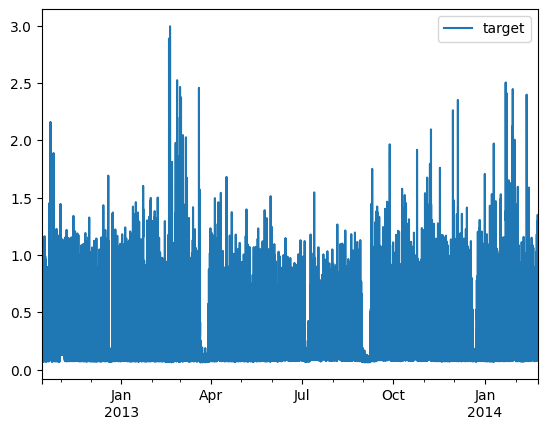

In [8]:
df.plot()

we can create a `PandasDataset` from a dataframe. There is also a `.from_long_dataframe()`method that handles multiple timeseries.

In [9]:
dataset = PandasDataset(df, target="target")

Let´s get the last 7 days as our test period

In [10]:
training_data, test_gen = split(dataset, offset=-48*7)

In [11]:
model = DeepAREstimator(
    context_length=48*3,
    prediction_length=48, 
    freq="30min", 
    trainer=Trainer(epochs=5)
).train(training_data)

100%|██████████| 50/50 [00:36<00:00,  1.36it/s, epoch=5/5, avg_epoch_loss=-1.11]


Negative loss? What´s the deal here? 

`DeepAR` is a probalistical model, it learns the parameters of a distribution. 

One of the most important parameters is `distr_output`. Here we should select a the distribution that our dataset follows. By default it uses a student T distribution.

If a distribution is not implemented, you can implement a new class, or easier... transform the data into the correct one.

Let´s visualize a forecasts on the test set

In [ ]:
test_data = test_gen.generate_instances(prediction_length=48, windows=7)

In [13]:
forecasts = list(model.predict(test_data.input))

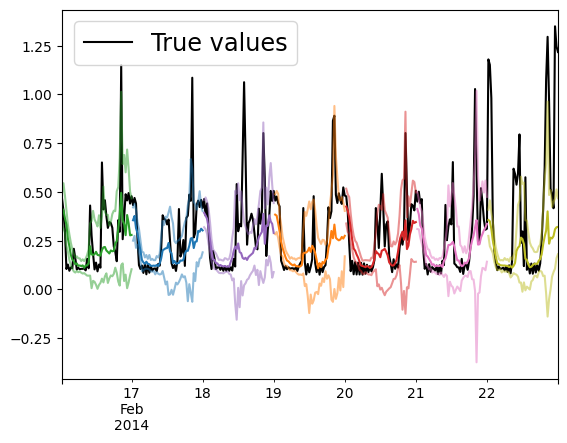

In [14]:
df.iloc[-48*7:]["target"].plot(color="black")

for forecast, color in zip(forecasts, ["green", "blue", "purple", "orange", "red", "pink", "olive"]):
    forecast.quantile_ts(0.1).plot(color=f"tab:{color}", alpha=0.5)
    forecast.quantile_ts(0.5).plot(color=f"tab:{color}")
    forecast.quantile_ts(0.9).plot(color=f"tab:{color}", alpha=0.5)

plt.legend(["True values"], loc="upper left", fontsize="xx-large")

It looks like the distribution is completely wrong! we can not have negative predictions as the lowest value is 0. Let´s apply a log transformation to the data.

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data.input,  # test dataset
    predictor=model,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(test_data.input)
)

Running evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.23it/s]


In [16]:
agg_metrics.keys()

dict_keys(['MSE', 'abs_error', 'abs_target_sum', 'abs_target_mean', 'seasonal_error', 'MASE', 'MAPE', 'sMAPE', 'MSIS', 'QuantileLoss[0.1]', 'Coverage[0.1]', 'QuantileLoss[0.2]', 'Coverage[0.2]', 'QuantileLoss[0.3]', 'Coverage[0.3]', 'QuantileLoss[0.4]', 'Coverage[0.4]', 'QuantileLoss[0.5]', 'Coverage[0.5]', 'QuantileLoss[0.6]', 'Coverage[0.6]', 'QuantileLoss[0.7]', 'Coverage[0.7]', 'QuantileLoss[0.8]', 'Coverage[0.8]', 'QuantileLoss[0.9]', 'Coverage[0.9]', 'RMSE', 'NRMSE', 'ND', 'wQuantileLoss[0.1]', 'wQuantileLoss[0.2]', 'wQuantileLoss[0.3]', 'wQuantileLoss[0.4]', 'wQuantileLoss[0.5]', 'wQuantileLoss[0.6]', 'wQuantileLoss[0.7]', 'wQuantileLoss[0.8]', 'wQuantileLoss[0.9]', 'mean_absolute_QuantileLoss', 'mean_wQuantileLoss', 'MAE_Coverage', 'OWA'])

In [17]:
agg_metrics["RMSE"]

0.15852601819496442

In [18]:
agg_metrics["sMAPE"]

0.373669045312064

Let´s add the log of the target 

In [19]:
df["log_target"] = np.log(df["target"])

In [20]:
dataset = PandasDataset(df, target="log_target")

In [21]:
training_data, test_gen = split(dataset, offset=-48*7)

In [22]:
model = DeepAREstimator(
    context_length=48*3,
    prediction_length=48, 
    freq="30min", 
    trainer=Trainer(epochs=5)
).train(training_data)

100%|██████████| 50/50 [00:38<00:00,  1.29it/s, epoch=5/5, avg_epoch_loss=0.468]


In [23]:
test_data = test_gen.generate_instances(prediction_length=48, windows=7)

In [24]:
forecasts = list(model.predict(test_data.input))

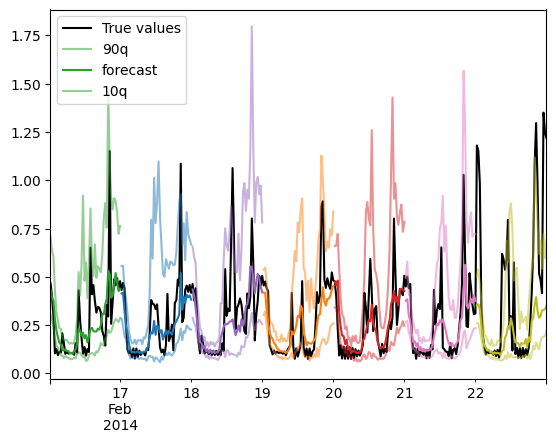

In [25]:
df.iloc[-48*7:]["target"].plot(color="black")

for forecast, color in zip(forecasts, ["green", "blue", "purple", "orange", "red", "pink", "olive"]):
    np.exp(forecast.quantile_ts(0.1)).plot(color=f"tab:{color}", alpha=0.5)
    np.exp(forecast.quantile_ts(0.5)).plot(color=f"tab:{color}")
    np.exp(forecast.quantile_ts(0.9)).plot(color=f"tab:{color}", alpha=0.5)

plt.legend(["True values", "90q", "forecast", "10q"], loc="upper left")

The forecast seem much better. The low and upper quantiles also look more reasonable

In [26]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data.input,  # test dataset
    predictor=model,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [27]:
forecasts = list(forecast_it)
actuals = list(ts_it)

In [28]:
agg_metrics, item_metrics = Evaluator()(
    actuals, forecasts, num_series=len(test_data.input)
)

Running evaluation: 100%|██████████| 7/7 [00:00<00:00, 45.23it/s]


In [29]:
agg_metrics["RMSE"]

0.42902478391634424

In [30]:
agg_metrics["sMAPE"]

0.262402389730726

The metric is calculated with the transformed data... we should scale it back to 

In [31]:
results = pd.DataFrame()

for ts, fc in zip(actuals, forecasts):
    df_tmp = pd.DataFrame()
    df_tmp["10q"] =  np.exp(fc.quantile_ts(0.1))
    df_tmp["y_hat"] = np.exp(fc.quantile_ts(0.5))
    df_tmp["90q"] =  np.exp(fc.quantile_ts(0.9))

    results = pd.concat([results, df_tmp])

results["y_true"] = df.loc[results.index, "target"]

<Axes: >

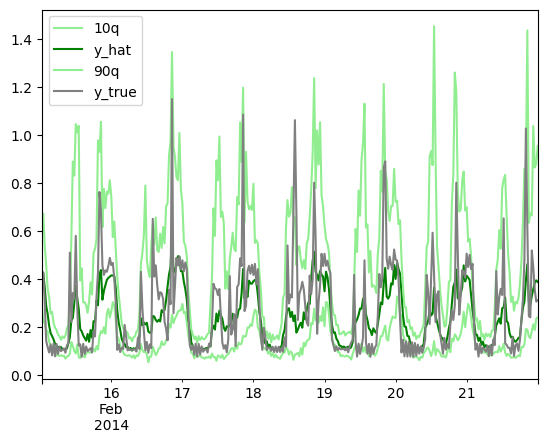

In [32]:
results.plot(color=["lightgreen", "green", "lightgreen", "grey"])

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
mean_absolute_error(results.y_true, results.y_hat)

0.08694417

In [35]:
mean_squared_error(results.y_true, results.y_hat, squared=False)

0.1357939

In [36]:
r2_score(results.y_true, results.y_hat)

0.4972046650142743

### Let´s try with another model

In [37]:
dataset = PandasDataset(df, target="target")

In [38]:
training_data, test_gen = split(dataset, offset=-48*7)

`Temporal Fusion Transformer` is a very versatile model that can handle many different types of features both known and un-known (not available at prediction time)

In [39]:
model = TemporalFusionTransformerEstimator(
    context_length=48*3,
    prediction_length=48, 
    freq="30min", 
    trainer=Trainer(epochs=5)   
).train(training_data)

100%|██████████| 50/50 [00:47<00:00,  1.05it/s, epoch=5/5, avg_epoch_loss=0.0282]


In [40]:
test_data = test_gen.generate_instances(prediction_length=48, windows=7)

In [41]:
forecasts = list(model.predict(test_data.input))

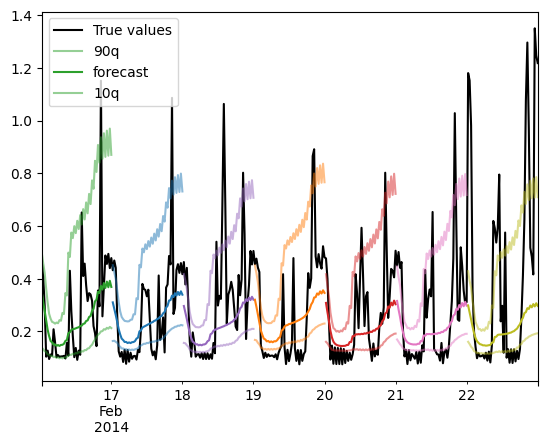

In [42]:
df.iloc[-48*7:]["target"].plot(color="black")

for forecast, color in zip(forecasts, ["green", "blue", "purple", "orange", "red", "pink", "olive"]):
    forecast.quantile_ts(0.1).plot(color=f"tab:{color}", alpha=0.5)
    forecast.quantile_ts(0.5).plot(color=f"tab:{color}")
    forecast.quantile_ts(0.9).plot(color=f"tab:{color}", alpha=0.5)

plt.legend(["True values", "90q", "forecast", "10q"], loc="upper left")

In [43]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data.input,  # test dataset
    predictor=model,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [44]:
agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(test_data.input)
)

Running evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.21it/s]


In [45]:
agg_metrics["RMSE"]

0.16171994216528665

GluonTS also comes with some pyTorch model implementations (DeepAR and TFT)

In [46]:
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.torch.model.tft import TemporalFusionTransformerEstimator

The syntax is slightly different. Note we don´t need to pass a Trainer, and we can pass other parameters to pyTorch lightning

In [47]:
model = TemporalFusionTransformerEstimator(
    context_length=48*3,
    prediction_length=48, 
    freq="30min", 
    trainer_kwargs={
        "max_epochs": 5,
    },
).train(training_data)

/workspaces/training-code/task_forecasting_training/.venv/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/workspaces/training-code/task_forecasting_training/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML eco

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 1.01154 (best 1.01154), saving model to '/workspaces/training-code/task_forecasting_training/notebooks/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 0.91251 (best 0.91251), saving model to '/workspaces/training-code/task_forecasting_training/notebooks/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 0.89567 (best 0.89567), saving model to '/workspaces/training-code/task_forecasting_training/notebooks/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 0.85930 (best 0.85930), saving model to '/workspaces/training-code/task_forecasting_training/notebooks/lightning_logs/version_

In [48]:
forecasts = list(model.predict(test_data.input))

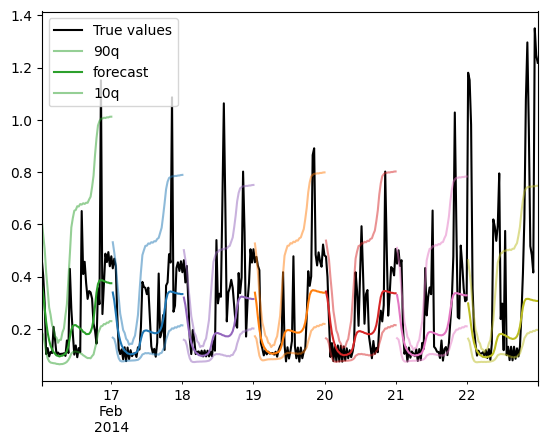

In [49]:
df.iloc[-48*7:]["target"].plot(color="black")

for forecast, color in zip(forecasts, ["green", "blue", "purple", "orange", "red", "pink", "olive"]):
    forecast.quantile_ts(0.1).plot(color=f"tab:{color}", alpha=0.5)
    forecast.quantile_ts(0.5).plot(color=f"tab:{color}")
    forecast.quantile_ts(0.9).plot(color=f"tab:{color}", alpha=0.5)

plt.legend(["True values", "90q", "forecast", "10q"], loc="upper left")

### NBeats is also another very interesting model

In [50]:
from gluonts.mx import NBEATSEstimator

In [51]:
model = NBEATSEstimator(
    freq="30min",
    prediction_length=48,
    context_length=48*3,
    trainer=Trainer(epochs=5)
).train(training_data)

100%|██████████| 50/50 [00:10<00:00,  4.83it/s, epoch=5/5, avg_epoch_loss=0.765]


In [52]:
forecasts = list(model.predict(test_data.input))

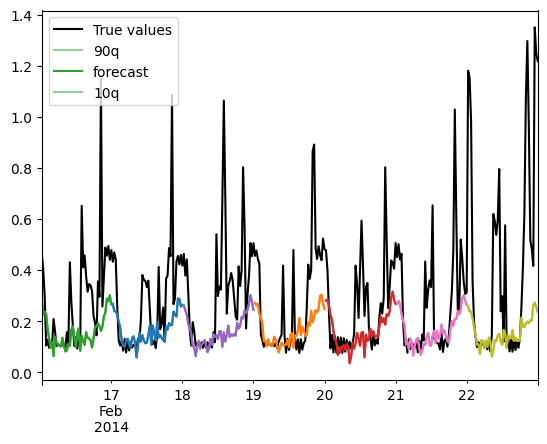

In [53]:
df.iloc[-48*7:]["target"].plot(color="black")

for forecast, color in zip(forecasts, ["green", "blue", "purple", "orange", "red", "pink", "olive"]):
    forecast.quantile_ts(0.1).plot(color=f"tab:{color}", alpha=0.5)
    forecast.quantile_ts(0.5).plot(color=f"tab:{color}")
    forecast.quantile_ts(0.9).plot(color=f"tab:{color}", alpha=0.5)

plt.legend(["True values", "90q", "forecast", "10q"], loc="upper left")

In [54]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data.input,  # test dataset
    predictor=model,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [55]:
agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(test_data.input)
)

Running evaluation: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


In [56]:
agg_metrics["RMSE"]

0.19636030695879944

Unfortunately NBeats is only a point estimate model, and doesnt provide prediction intervals

### GluonTS comes with many models. Try some others and find which one is more suitable for our problem.

In [57]:
from gluonts.mx import WaveNetEstimator

In [58]:
model = WaveNetEstimator(
    freq="30min",
    prediction_length=48,
    seasonality=48,
    trainer=Trainer(epochs=5)
).train(training_data)

100%|██████████| 50/50 [00:29<00:00,  1.67it/s, epoch=5/5, avg_epoch_loss=5.07]


In [59]:
forecasts = list(model.predict(test_data.input))

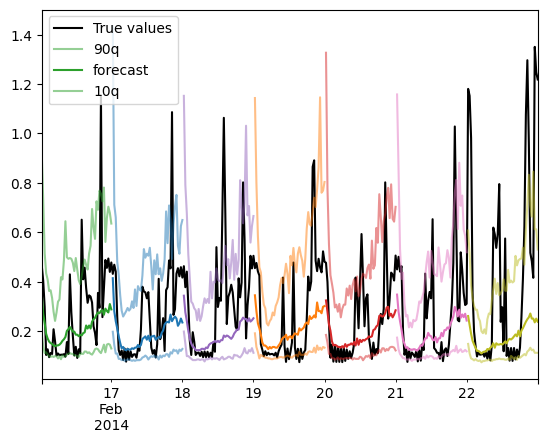

In [60]:
df.iloc[-48*7:]["target"].plot(color="black")

for forecast, color in zip(forecasts, ["green", "blue", "purple", "orange", "red", "pink", "olive"]):
    forecast.quantile_ts(0.1).plot(color=f"tab:{color}", alpha=0.5)
    forecast.quantile_ts(0.5).plot(color=f"tab:{color}")
    forecast.quantile_ts(0.9).plot(color=f"tab:{color}", alpha=0.5)

plt.legend(["True values", "90q", "forecast", "10q"], loc="upper left")

In [61]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data.input,  # test dataset
    predictor=model,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [62]:
agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(test_data.input)
)

Running evaluation: 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


In [63]:
agg_metrics["RMSE"]

0.16038977647381328

Gluonts has many models.  Try some others...

https://ts.gluon.ai/stable/getting_started/models.html

In [64]:
from gluonts.mx import ...

SyntaxError: invalid syntax (3035660612.py, line 1)

In [ ]:
dataset = PandasDataset(df, target="log_target")

In [ ]:
training_data, test_gen = split(dataset, offset=-48*7)

In [ ]:
model = ...(
    freq="30min",
    prediction_length=48,
    context_length=48*3,
    trainer=Trainer(epochs=25)
).train(training_data)

100%|██████████| 50/50 [00:24<00:00,  2.06it/s, epoch=25/25, avg_epoch_loss=3.56]


## TODO: 

#### Now run the models on the whole dataset, and find which of the models performs best! 

#### Do the models perform better when trained on all the data? Compare the results for the first time series.